Specifically, in this post, I'll talk about:

-Matrix Factorisation in Keras

-Adding non-negativitiy constraints to solve non-negative matrix factorisation (NNMF)

-Using neural networks for recommendations

# Select dataset to process

In [1]:
#@title
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dt_dir_name= "C:/Users/jiyu/Desktop/Mo/sample_data/processed"

In [4]:
#dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])

dataset = pd.read_csv(dt_dir_name +'/'+ 'implicit_rating.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ml1m_ns.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])




In [5]:
dataset.head()

user_id  item_id  rating  timestamp
0        1     1193       1  978300760
1        1      661       1  978302109
2        1      914       1  978301968
3        1     3408       1  978300275
4        1     2355       1  978824291

In [6]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(6040, 3706)

We assign a unique number between (0, #users) to each user and do the same for movies.


In [7]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [8]:
#dataset.rating

In [9]:
dataset.head()

user_id  item_id  rating  timestamp
0        0     1104       1  978300760
1        0      639       1  978302109
2        0      853       1  978301968
3        0     3177       1  978300275
4        0     2162       1  978824291

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset.rating = scaler.fit_transform(dataset[['rating']])

In [10]:
dataset.tail()

user_id  item_id  rating  timestamp
1000204     6039     1019       1  956716541
1000205     6039     1022       1  956704887
1000206     6039      548       1  956704746
1000207     6039     1024       1  956715648
1000208     6039     1025       1  956715569

In [11]:
train, test = train_test_split(dataset, test_size=0.2)

One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: $A≈W.HT$

In [12]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model


In [13]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
import math


#Create MF model using Keras

In [14]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 16
# l1=1e-5
# l2=1e-4

In [15]:
from tensorflow import keras

In [ ]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors, embeddings_regularizer=l2(1e-6), name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users, n_latent_factors, embeddings_regularizer=l2(1e-6), name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

concat = keras.layers.concatenate([movie_vec, user_vec])

mlp = concat
for i in range(3,-1,-1):
  if i == 0:
    mlp = Dense(8**i, activation='sigmoid',
                name="output")(mlp)
  else:
    mlp = Dense(8*2**i, activation='sigmoid',
                kernel_regularizer=l1_l2(1e-5, 1e-4))(mlp)
    if i >= 2:
      mlp = BatchNormalization()(mlp)
      mlp = Dropout(0.2)(mlp)

model = Model(inputs=[user_input, movie_input], outputs=[mlp])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy','MAPE', 'mse'])

In [17]:
#Choose metrics from keras
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        59296       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        96640       User[0][0]                       
______________________________________________________________________________________________

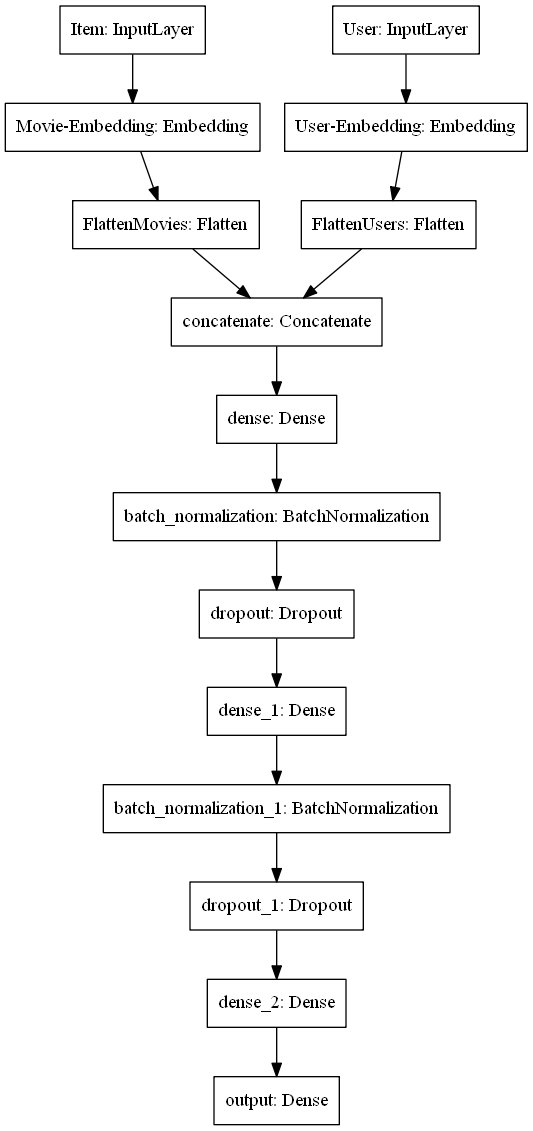

In [19]:
tf.keras.utils.plot_model(model, to_file='model.png')

##Create data generator class

The class generate the sample for training dynamically

In [20]:
class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size=16, dim=(1), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = dataset.index
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(len(self.dataset) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]

        # Find list of IDs
        list_IDs_temp = [self.indexes[k] for k in idxs]

        # Generate data
        User = dataset.loc[list_IDs_temp,['user_id']].to_numpy()#.reshape(-1)
        Item = dataset.loc[list_IDs_temp,['item_id']].to_numpy()#.reshape(-1)
        y = dataset.loc[list_IDs_temp,['rating']].to_numpy()#.reshape(-1)
        #print("u,i,r:", [User, Item],[y])
        return [User, Item],[y]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


##Trainging the model (2 options)

 - Normal fit
 - Fit generator

In [ ]:
#1 Normal training with fit method (uncomment to run)

#history = model.fit([train.user_id, train.item_id], train.rating, epochs=50, verbose=1)#

In [21]:
#2  training with fit generator
train_generator = DataGenerator(dataset=train, batch_size=32)
history = model.fit(train_generator, epochs=10)

Train for 25006 steps
Epoch 1/10
    1/25006 [..............................] - ETA: 8:24:39

InternalError: 2 root error(s) found.
  (0) Internal:  Blas GEMM launch failed : a.shape=(32, 32), b.shape=(32, 64), m=32, n=64, k=32
	 [[node model/dense/MatMul (defined at <ipython-input-21-7ac8234cb089>:3) ]]
	 [[AddN_5/_66]]
  (1) Internal:  Blas GEMM launch failed : a.shape=(32, 32), b.shape=(32, 64), m=32, n=64, k=32
	 [[node model/dense/MatMul (defined at <ipython-input-21-7ac8234cb089>:3) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_2487]

Function call stack:
distributed_function -> distributed_function


In [ ]:
#Result of normal fit
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['mae']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','mae'])

In [ ]:
#Result of fit generator
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['mae']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','mae'])

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [ ]:
results = model.evaluate((test.user_id, test.item_id), test.rating,
                            batch_size=1)

In [ ]:
print(results)

In [ ]:
#y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_hat = model.predict([test.user_id, test.item_id])
y_true = test.rating

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

#Extracting the learnt embeddings
We can extract the learnt movie and item embeddings as follows:

In [ ]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

In [ ]:
user_embedding_learnt

In [ ]:
user_embedding_learnt.shape

In [ ]:
#SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

#Recommend top n movies

In [ ]:
def recommend(user_id, number_of_movies=5):
  movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
  mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
  return mids

In [ ]:
recommend(user_id=1)

#Experimental results:
1. array([ 482,   56, 1462, 1397, 1642]) --> normal training (fit) 100 epoches
2. array([1638,  118, 1466, 1448, 1627]) --> generator training (fit_generator) 20 epoches
3. array([ 901,  319, 1404, 1448, 1642])--> generator training (fit_generator) 50 epoches


#References
https://nipunbatra.github.io/blog/2017/recommend-keras.html

https://medium.com/sfu-big-data/recommendation-systems-collaborative-filtering-using-matrix-factorization-simplified-2118f4ef2cd3

[Keras regularizer](https://keras.io/regularizers/)